In [1]:
import carla
import random
import os
import pkg_resources
from pathlib import Path
import shutil
import time
import numpy as np
from pascal_voc_writer import Writer
import queue
import matplotlib.pyplot as plt
from tqdm import tqdm
# Connect to the client and retrieve the world object
client = carla.Client('localhost', 2000)

# Running a traffic scene:

* ego in lane
* lead vehicle is stationary and blocks the lane
* oncoming traffic

In [2]:
version = pkg_resources.get_distribution("carla").version
# hmm, shit, 0.10.0 has only 2 maps... and Mine_1 is not really normal roads.
print(version)
client.get_available_maps()

0.10.0


['/Game/Carla/Maps/Mine_01', '/Game/Carla/Maps/Town10HD_Opt']

In [3]:
# https://carla.readthedocs.io/en/latest/tuto_first_steps/
# client.load_world('/Game/Carla/Maps/Mine_01')
world = client.get_world()
print(world.get_map().name)
map = world.get_map()
spawn_points = map.get_spawn_points()

Carla/Maps/Town10HD_Opt


In [4]:
# remove all actors when starting over again.
actors = world.get_actors()

# Filter out only vehicles, walkers, and sensors
vehicles = actors.filter("vehicle.*")
walkers = actors.filter("walker.*")
sensors = actors.filter("sensor.*")

# Destroy all actors
for actor_list in [vehicles, walkers, sensors]:
    for actor in actor_list:
        actor.destroy()

print("All non-static actors removed!")

All non-static actors removed!


In [ ]:
# Spawn some vehicle to have some traffic if necessary

# vehicle_blueprints = world.get_blueprint_library().filter('*vehicle*')
# for i in range(0,10):
#     world.try_spawn_actor(random.choice(vehicle_blueprints), random.choice(spawn_points))
# for vehicle in world.get_actors().filter('*vehicle*'):
#    vehicle.set_autopilot(True)

In [5]:
# some small helper functions, some taken from the Carla documentation. 

def find_straight_road_spawn(min_distance=200.0, yaw_tolerance=10):
    """
    Finds a spawn point where the next `min_distance` meters is relatively straight.
    Increases yaw tolerance to allow minor road curves.
    """
    for spawn_point in spawn_points:
        ego_waypoint = map.get_waypoint(spawn_point.location)
        # Get waypoints ahead within min_distance
        waypoints_ahead = ego_waypoint.next(min_distance)
        if len(waypoints_ahead) == 0:
            continue
        is_straight = all(
            abs(waypoint.transform.rotation.yaw - ego_waypoint.transform.rotation.yaw) < yaw_tolerance
            for waypoint in waypoints_ahead
        )
        if is_straight:
            ego_waypoint.lane_type
            left_lane = ego_waypoint.get_left_lane()
            right_lane = ego_waypoint.get_right_lane()
            if (np.abs(left_lane.transform.rotation.yaw -  ego_waypoint.transform.rotation.yaw) > 10) & (right_lane.lane_type == carla.LaneType.Shoulder):         
                return spawn_point  
    return None

def update_spectator():
   transform = ego_vehicle.get_transform()
   camera_location = transform.location + carla.Location(x=0, y=0, z=3)
   camera_rotation = carla.Rotation(pitch=-15, yaw=transform.rotation.yaw, roll=0)
   spectator.set_transform(carla.Transform(camera_location, camera_rotation))


def build_projection_matrix(w, h, fov, is_behind_camera=False):
    focal = w / (2.0 * np.tan(fov * np.pi / 360.0))
    K = np.identity(3)

    if is_behind_camera:
        K[0, 0] = K[1, 1] = -focal
    else:
        K[0, 0] = K[1, 1] = focal

    K[0, 2] = w / 2.0
    K[1, 2] = h / 2.0
    return K

def get_image_point(loc, K, w2c):
        # Calculate 2D projection of 3D coordinate

        # Format the input coordinate (loc is a carla.Position object)
        point = np.array([loc.x, loc.y, loc.z, 1])
        # transform to camera coordinates
        point_camera = np.dot(w2c, point)

        # New we must change from UE4's coordinate system to an "standard"
        # (x, y ,z) -> (y, -z, x)
        # and we remove the fourth componebonent also
        point_camera = [point_camera[1], -point_camera[2], point_camera[0]]

        # now project 3D->2D using the camera matrix
        point_img = np.dot(K, point_camera)
        # normalize
        point_img[0] /= point_img[2]
        point_img[1] /= point_img[2]

        return point_img[0:2]

### Pick a place:

In [6]:
# rerun cell, if error is returned
random.seed(10000)
random.shuffle(spawn_points)
ego_straight_spawn_point = find_straight_road_spawn(min_distance=45)
print(type(ego_straight_spawn_point))
print(ego_straight_spawn_point.location.x, ego_straight_spawn_point.location.y)

way_point = map.get_waypoint(ego_straight_spawn_point.location)
left_lane = way_point.get_left_lane()
right_lane = way_point.get_right_lane()
print(left_lane.transform.rotation.yaw, way_point.transform.rotation.yaw, right_lane.lane_type)

<class 'carla.Transform'>
-27.022132873535156 69.71400451660156
-179.92672729492188 0.073272705078125 Shoulder


### Create the ego:

In [7]:
blueprint_library = world.get_blueprint_library()
ego_vehicle_bp = random.choice(blueprint_library.filter("vehicle.nissan.patrol"))
ego_vehicle = world.spawn_actor(ego_vehicle_bp, ego_straight_spawn_point)

spectator = world.get_spectator()
update_spectator()

### Create the broken vehicle:

In [8]:
BROKEN_DOWN_DISTANCE = 40.0
broken_location = ego_straight_spawn_point.location + carla.Location(y=0, x=BROKEN_DOWN_DISTANCE, z=0)
broken_down_waypoint = map.get_waypoint(broken_location)
broken_down_waypoint

print(broken_down_waypoint.transform.location.x, broken_down_waypoint.transform.location.y)

broken_spawn_point = broken_down_waypoint.transform
broken_spawn_point.location.z += 0.5  # Prevent underground spawns

broken_vehicle_bp = random.choice(blueprint_library.filter("vehicle.*"))
broken_vehicle = world.spawn_actor(broken_vehicle_bp, broken_spawn_point)


12.97779655456543 69.76515197753906


### Create oncoming traffic:

In [9]:
ONCOMING_DISTANCE = 50.0
oncomming_location = ego_straight_spawn_point.location + carla.Location(y=0, x=ONCOMING_DISTANCE, z=0)
oncoming_waypoint = map.get_waypoint(oncomming_location)
oncoming_waypoint = oncoming_waypoint.get_left_lane()

oncoming_spawn_point = oncoming_waypoint.transform
oncoming_spawn_point.location.z += 0.5  # Prevent underground spawns

oncoming_bp = random.choice(blueprint_library.filter("vehicle.*"))
oncoming_vehicle = world.spawn_actor(oncoming_bp, oncoming_spawn_point)


### Setup camera to collect images:

* Also swith sim to synchronous mode.

In [10]:
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_init_trans = carla.Transform(carla.Location(x = 1, z=2))
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=ego_vehicle)

In [11]:
# Set up the simulator in synchronous mode
settings = world.get_settings()
# Enables synchronous mode
settings.synchronous_mode = True 
settings.fixed_delta_seconds = 0.1
world.apply_settings(settings)

# Create a queue to store and retrieve the sensor data
image_queue = queue.Queue()
camera.listen(image_queue.put)

### Show the start of the scene:

* and safe some constants

In [12]:
# Retrieve and reshape the image
world.tick()
image = image_queue.get()
img = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))
# Get the camera matrix 
world_2_camera = np.array(camera.get_transform().get_inverse_matrix())

# Get the world to camera matrix
world_2_camera = np.array(camera.get_transform().get_inverse_matrix())

# Get the attributes from the camera
image_w = camera_bp.get_attribute("image_size_x").as_int()
image_h = camera_bp.get_attribute("image_size_y").as_int()
fov = camera_bp.get_attribute("fov").as_float()

# Calculate the camera projection matrix to project from 3D -> 2D
K = build_projection_matrix(image_w, image_h, fov)
K_b = build_projection_matrix(image_w, image_h, fov, is_behind_camera=True)

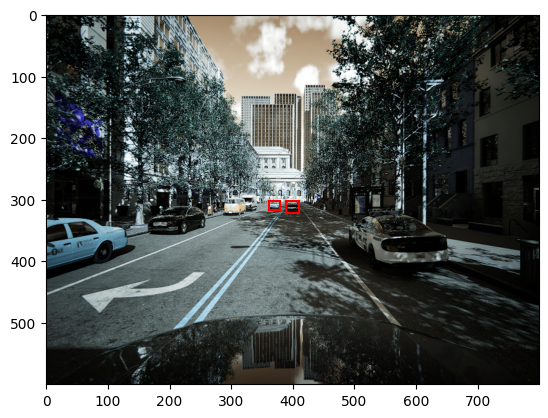

In [13]:
plt.imshow(img)
for npc in world.get_actors().filter('*vehicle*'):
    if npc.id != ego_vehicle.id:

        bb = npc.bounding_box
        dist = npc.get_transform().location.distance(ego_vehicle.get_transform().location)

        # Filter for the vehicles within 50m
        if dist < 70:
            forward_vec = ego_vehicle.get_transform().get_forward_vector()
            ray = npc.get_transform().location - ego_vehicle.get_transform().location
            if forward_vec.dot(ray) > 0:
                p1 = get_image_point(bb.location, K, world_2_camera)
                verts = [v for v in bb.get_world_vertices(npc.get_transform())]
                x_max = -10000
                x_min = 10000
                y_max = -10000
                y_min = 10000

                for vert in verts:
                    p = get_image_point(vert, K, world_2_camera)
                    # Find the rightmost vertex
                    if p[0] > x_max:
                        x_max = p[0]
                    # Find the leftmost vertex
                    if p[0] < x_min:
                        x_min = p[0]
                    # Find the highest vertex
                    if p[1] > y_max:
                        y_max = p[1]
                    # Find the lowest  vertex
                    if p[1] < y_min:
                        y_min = p[1]
                plt.plot([int(x_min), int(x_max)], [int(y_min), int(y_min)], color = 'red')
                plt.plot([int(x_min), int(x_max)], [int(y_max), int(y_max)], color = 'red')
                plt.plot([int(x_min), int(x_min)], [int(y_min), int(y_max)], color = 'red')
                plt.plot([int(x_max), int(x_max)], [int(y_min), int(y_max)], color = 'red')
plt.show()


### run the sceene and store images and ground truth data:

* storing gt as described here: https://carla.readthedocs.io/en/latest/tuto_G_bounding_boxes/

In [14]:

oncoming_vehicle.set_autopilot(True)
ego_vehicle.set_autopilot(True)

for i in tqdm(range(100)):
    update_spectator()
    world.tick()
    image = image_queue.get()

    # Get the camera matrix 
    world_2_camera = np.array(camera.get_transform().get_inverse_matrix())

    frame_path = 'output/%06d' % image.frame

    # Save the image
    image.save_to_disk(frame_path + '.png')

    # Initialize the exporter
    writer = Writer(frame_path + '.png', image_w, image_h)

    for npc in world.get_actors().filter('*vehicle*'):
        if npc.id != ego_vehicle.id:
            bb = npc.bounding_box
            dist = npc.get_transform().location.distance(ego_vehicle.get_transform().location)
            if dist < 50:
                forward_vec = ego_vehicle.get_transform().get_forward_vector()
                ray = npc.get_transform().location - ego_vehicle.get_transform().location
                if forward_vec.dot(ray) > 0:
                    p1 = get_image_point(bb.location, K, world_2_camera)
                    verts = [v for v in bb.get_world_vertices(npc.get_transform())]
                    x_max = -10000
                    x_min = 10000
                    y_max = -10000
                    y_min = 10000
                    for vert in verts:
                        p = get_image_point(vert, K, world_2_camera)
                        if p[0] > x_max:
                            x_max = p[0]
                        if p[0] < x_min:
                            x_min = p[0]
                        if p[1] > y_max:
                            y_max = p[1]
                        if p[1] < y_min:
                            y_min = p[1]

                    # Add the object to the frame (ensure it is inside the image)
                    if x_min > 0 and x_max < image_w and y_min > 0 and y_max < image_h: 
                        writer.addObject('vehicle', x_min, y_min, x_max, y_max)

    # Save the bounding boxes in the scene
    writer.save(frame_path + '.xml')



100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
